# Plot polar maps of boreal domain data 
Paul Montesano  
Fall 2022  
run this notebook in a conda R env

In [1]:
system("conda activate r-with-gdal")

['bash: conda activate r-with-gdal: command not found']

In [4]:
library(aws.s3)
library(rgdal)
library(raster)
library(tidyverse)
library(dplyr)
library(grid)
library(gridExtra)
library(RColorBrewer)
library(data.table)

library(fs)
library(sf)
library(rgdal)


library(rgeos)
library(mapproj)
#library(rgee)
library(viridis)
library(wesanderson)
library(scales)
library(tools)
library(patchwork)

library(rnaturalearth)
library(rnaturalearthdata)
library(feather)

#conda install -c conda-forge r-rnaturalearth r-rnaturalearthdata r-mapproj r-rgeos r-viridis r-wesanderson r-patchwork r-aws.s3 r-feather r-rockchalk

ERROR: Error in library(aws.s3): there is no package called ‘aws.s3’


# Paths of final tindex master files

In [72]:
# This is the final list of HLS tiles that include the fixed (45) tiles
hls_params_fn = "s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/c2020/HLS_stack_2022_v2/HLS_input_params.csv"

# Replace this with final
#AGB_tindex_master_fn = "s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/AGB/fall2022/map_boreal_2022_v3/11/AGB_tindex_master.csv"
#AGB_tindex_master_fn = "s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/AGB/winter2023/map_boreal_2022_rh_noground_v4/AGB_tindex_master.csv"
# Final file
AGB_tindex_master_fn = "s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/AGB/c2020/map_boreal_2022_rh_noground_v4/AGB_tindex_master.csv"

# Final file
ATL08_filt_tindex_master_fn = "s3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/with_atl03_rh/ATL08_filt_tindex_master.csv"

## Set output figure dir.

In [52]:
OUT_FIGURE_DIR = '/projects/my-public-bucket/boreal_polar_map/paper_figs'

### Mapping functions and vars

In [22]:
source('/projects/code/3dsi/boreal_map_functions.R') 

[1] "MAAP"
[1] "MAAP"


#### Note: the ability to make these maps is changing...

The use of type 'SpatialPolygons' will go away.  
This means 'crop' will need to be changed to crop an 'sf' object.

But the whole polar mapping function is built around the use of 'SP', not 'sf'.-  

THis will need work and testing to be able to reproduce these polar maps.

At the moment, these still works in `r-env-3.6.3` on Prism

In [1]:
# Circ map new: trying to combine the best of the sf and sp approaches
DO_MAP_BOREAL_SP <- function( MAP_EXTENT = extent(-180,180,45,90), xlim=NULL, ylim=NULL, rotate_map=0, proj_name = 'azequalarea', LAYER_LIST=NULL, 
                             BOREAL_SHP_FN = '/projects/my-public-bucket/misc_files/Ecoregions2017_boreal_m.shp'){
  #
  # Map with a polar projection
  #
  
  # Color scale help
  #https://biostats.w.uib.no/color-scale-for-continuous-variables/
  
  #source(path("C:\\Users\\pmontesa\\Google Drive\\Work\\R","plot_functions.R"))
  # Shapefiles
  
  
  #world <- crop(ne_countries(scale = "medium", returnclass = "sp"), MAP_EXTENT)
  world <- raster::crop(as(ne_countries(scale = "medium", returnclass = "sf"), 'Spatial'), MAP_EXTENT)
  #world = st_crop(x = ne_countries(scale = "medium", returnclass = "sf") %>% st_make_valid() ,  y = ext)
  
  # WWF
  #boreal <- shp_fort_join("D:\\databank\\wwf\\arc\\wwf_circumboreal_Dissolve.shp", MAP_EXTENT, REPROJECT = TRUE)
  # TerraPulse
  boreal <- shp_fort_join(boreal_shp_fn, MAP_EXTENT, REPROJECT = TRUE)
  
  map_list_base = list(
    
    geom_polygon(data = fortify(world), aes(x = long, y = lat, group = group), fill="grey90", color=NA),
    geom_polygon(data = boreal, aes(x = long, y = lat, group = group), color=NA, fill="grey70"))
    
  map_list_top = list(
    
    geom_polygon(data = fortify(world), aes(x = long, y = lat, group = group), fill=NA, color="black", size=0.1 ),
    
    theme_minimal() , 
    theme(axis.text = element_blank(), axis.title = element_blank() ) ,
    
    #geom_polygon(data = fortify(continents.df_stereo), aes(x = long, y = lat, group = group), fill = NULL, colour = "black", size=0.25) +
    #scale_color_distiller(palette = "Greens", direction = 1, name = "%"),
    #scale_color_manual(values = COLOR_PAL, name = map_str) ,
    guides(guide = guide_legend(direction = "horizontal", nrow=1, label.position = "bottom", title.position = "bottom") ) ,
    theme(legend.position="top",
          legend.title = element_text(size=9),
          #       legend.direction  = 'vertical',
          legend.key.width  = unit(1.0, "cm"),
          legend.key.height = unit(.25, "cm")  )
  )
  
  if(is.null(LAYER_LIST)){
    map_list = list(
      map_list_base,
      map_list_top
    )
  }else{
    map_list = list(
      map_list_base,
      LAYER_LIST,
      map_list_top
    )
  }
  
  p_map = ggplot() + map_list +
    #coord_map_stereo_list(proj_name = proj_name, min_lat = MAP_EXTENT[3], rotation=rotate_map, xlim = xlim, ylim = ylim)
    coord_map_stereo_list(proj_name = proj_name, min_lat = MAP_EXTENT[3], rotation=rotate_map)
  
  if(FALSE){
    out_plot_fn = paste0("D:/projects/3dsi/plots/map_boreal_",proj_name,"_", format(Sys.time(), "_%Y%m%d"),'.png')
    print(out_plot_fn)
    ggsave(plot = p_map ,
           file = out_plot_fn,
           device = 'png', dpi = 300, width = 5, height = 5)
  }
  #print(p_map)
  return(p_map)
  
}

coord_map_stereo_list <- function(proj_name = "stereo", rotation = 0, min_lat = 50, xlims=NULL, ylims=NULL, LABEL_SIZE=3){ 
  
  # Defines the x axes required
  lat_lines = seq(min_lat+10, 80, by = 10)
  lat_labs = paste0(seq(min_lat+10, 80, by = 10), "\u00B0N")
  
  lon_lines = seq(0, 330, by = 30)
  lon_labs = c("0", paste0(seq(30, 150, by = 30), "°E"), "180", rev(paste0(seq(30, 150, by = 30), "°W")))
  
  
  return(list(
    # Convert to polar coordinates
    coord_map(proj_name, orientation = c(90, 0, rotation, xlims=xlims, ylims=ylims)), #"ortho""
    scale_y_continuous(breaks = seq(45, 90, by = 5), labels = NULL),
    
    # Removes Axes and labels
    scale_x_continuous(breaks = NULL),
    xlab(""),
    ylab(""),
    
    # Adds axes
    # Latitude
    geom_hline(aes(yintercept = lat_lines), size = 0.25, color = "grey80", linetype = "dotted"),
    # Outer circular border
    geom_hline(aes(yintercept = min_lat), size = 0.25), #1
    # Longitude
    geom_vline(aes(xintercept = lon_lines), size = 0.25, color = "grey80", linetype = "dotted"),
    #geom_segment(aes(y = 45, yend = 85, x = x_lines, xend = x_lines), linetype = "dotted") +
    
    # Adds labels
    #geom_text(aes(x = 0, y = lat_lines, hjust = 0.5, label = lat_labs)),
    geom_label(aes(x = 0, y = lat_lines, label = lat_labs), label.size = NA, size=LABEL_SIZE, color = "black", fill="white", label.padding=unit(0.1,"lines")),
    #geom_text(aes(x = lon_lines, y = min_lat-3, hjust = 0.5, vjust = 0.5, label = lon_labs), size = 2.5), #hjust = 0.5
    # min-3 so lon labels are centered over outer line
    geom_label(aes(x = lon_lines, y = min_lat-3, label = lon_labs), label.size = NA,  hjust='inward', vjust='inward', size = LABEL_SIZE, color = "black", fill="white", label.padding=unit(0.1,"lines")),  #y = min_lat-3 why used to be this?
    
    ##guides(fill=FALSE)+
    
    # Change theme to remove axes and ticks
    theme(panel.background = element_blank(),
          #panel.grid = element_line(size = 0.25, linetype = 'dotted', colour = "grey50"),
          axis.ticks=element_blank())
    #,
    #labs(caption = "Source: circ_tte_map.Rmd")
  ))
}  
shp_fort_join = function(shapefile_fn, ext, REPROJECT=FALSE){

  shp_name = tools::file_path_sans_ext(basename(shapefile_fn))
  shp = readOGR(shapefile_fn, layer = shp_name)
  # Test this, so you can read in geojson and gpkg
  #shp = sf::st_read(shapefile_fn)

  if(REPROJECT){
      # Shapefile reprojection to geog
      geog_proj4 = '+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0'
      shp <- spTransform(shp, geog_proj4)
  }

  shp <- crop(shp, ext)
  
  #Get attributes, fortify data, and merge attributes to data
  tbl = shp@data
  tbl$id <- rownames(tbl)
  shp.df <- ggplot2::fortify(shp, id = "id")
  
  return(plyr::join(shp.df, tbl, by = "id"))
}

gridCreate<-function(shp, res,proj_out, buffer=10000){
  
  if (!is.null(buffer)){
    shp<-buffer(shp, width=buffer)
  }
  ext <- floor(extent(shp))
  rr <- raster(ext, res=res)
  rr <- rasterize(shp, rr, field=1)
  rr[!is.na(rr[])]<-1:length(rr[!is.na(rr[])])
  grid<-rasterToPolygons(rr)
  crs(grid)<-projection(shp)
  if (!proj_out==projection(shp)){
    grid<-spTransform(grid,CRS(proj_out))
  }
  return(grid)  
}



In [2]:
crs_canalb = "+proj=aea +lat_0=40 +lon_0=180 +lat_1=50 +lat_2=70 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"
crs_albers = "+proj=aea +lat_1=50 +lat_2=70 +lat_0=40 +lon_0=180 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"
crs_gcs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

# Map Boreal EXTENT

#### Read boreal extent, read tiles, then clip tiles to boreal extent

In [3]:
boreal_shp_fn = '/projects/my-public-bucket/misc_files/Ecoregions2017_boreal_m.shp'
boreal_shp_fn = '/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson'
boreal = st_read(boreal_shp_fn)
boreal_albers<-spTransform(sf:::as_Spatial(boreal),CRS(crs_albers))

ERROR: Error in st_read(boreal_shp_fn): could not find function "st_read"


In [26]:
boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg'
boreal_tiles_clip = st_intersection(
                                st_read(boreal_tile_index_path) %>% st_transform(crs="+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"), 
                                boreal)#%>% as.data.frame()

Reading layer `boreal_tiles_v003' from data source 
  `/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg' 
  using driver `GPKG'
Simple feature collection with 5337 features and 4 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -6111478 ymin: 1233304 xmax: 6308522 ymax: 10323300
Projected CRS: unnamed


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


#### Get only the boreal tile nums that coincide with the boreal extent

In [10]:
#head(boreal_tiles_clip%>% as.data.frame())
boreal_tile_num_list = boreal_tiles_clip %>% as.data.frame() %>% dplyr::select(tile_num) %>% as.list()
boreal_tile_num_list = unlist(boreal_tile_num_list[[1]])
length(boreal_tile_num_list)

[1] 3015

### Get all tiles delivered to DAAC for this project

In [45]:
boreal_tile_DAAC_index_path = '/projects/shared-buckets/montesano/boreal_tiles_v003_DAAC.gpkg'
boreal_tiles_DAAC = st_read(boreal_tile_DAAC_index_path)
boreal_tile_num_DAAC_list =  boreal_tiles_DAAC %>% as.data.frame() %>% dplyr::select(tile_num) %>% as.list()
boreal_tile_num_DAAC_list = unlist(boreal_tile_num_DAAC_list[[1]])
length(boreal_tile_num_DAAC_list)

Reading layer `boreal_tiles_v003_DAAC' from data source 
  `/projects/shared-buckets/montesano/boreal_tiles_v003_DAAC.gpkg' 
  using driver `GPKG'
Simple feature collection with 3891 features and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -179.8182 ymin: 43.70499 xmax: 178.3993 ymax: 78.53133
Geodetic CRS:  WGS 84


[1] 3891

## Map showing boreal tile extent

In [29]:
ext = extent(-180,180,40,90)

In [30]:
boreal_tiles_gcs = shp_fort_join(boreal_tile_index_path, ext, REPROJECT=TRUE)

Warning message in OGRSpatialRef(dsn, layer, morphFromESRI = morphFromESRI, dumpSRS = dumpSRS, :
“Discarded datum unknown in Proj4 definition: +proj=aea +lat_0=40 +lon_0=180 +lat_1=50 +lat_2=70 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs,
 but +towgs84= values preserved”


OGR data source with driver: GPKG 
Source: "/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg", layer: "boreal_tiles_v003"
with 5337 features
It has 4 fields
Integer64 fields read as strings:  tile_num 


Regions defined for each Polygons



OGR data source with driver: GeoJSON 
Source: "/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson", layer: "wwf_circumboreal_Dissolve"
with 2 features
It has 4 fields


Regions defined for each Polygons

Regions defined for each Polygons

Regions defined for each Polygons



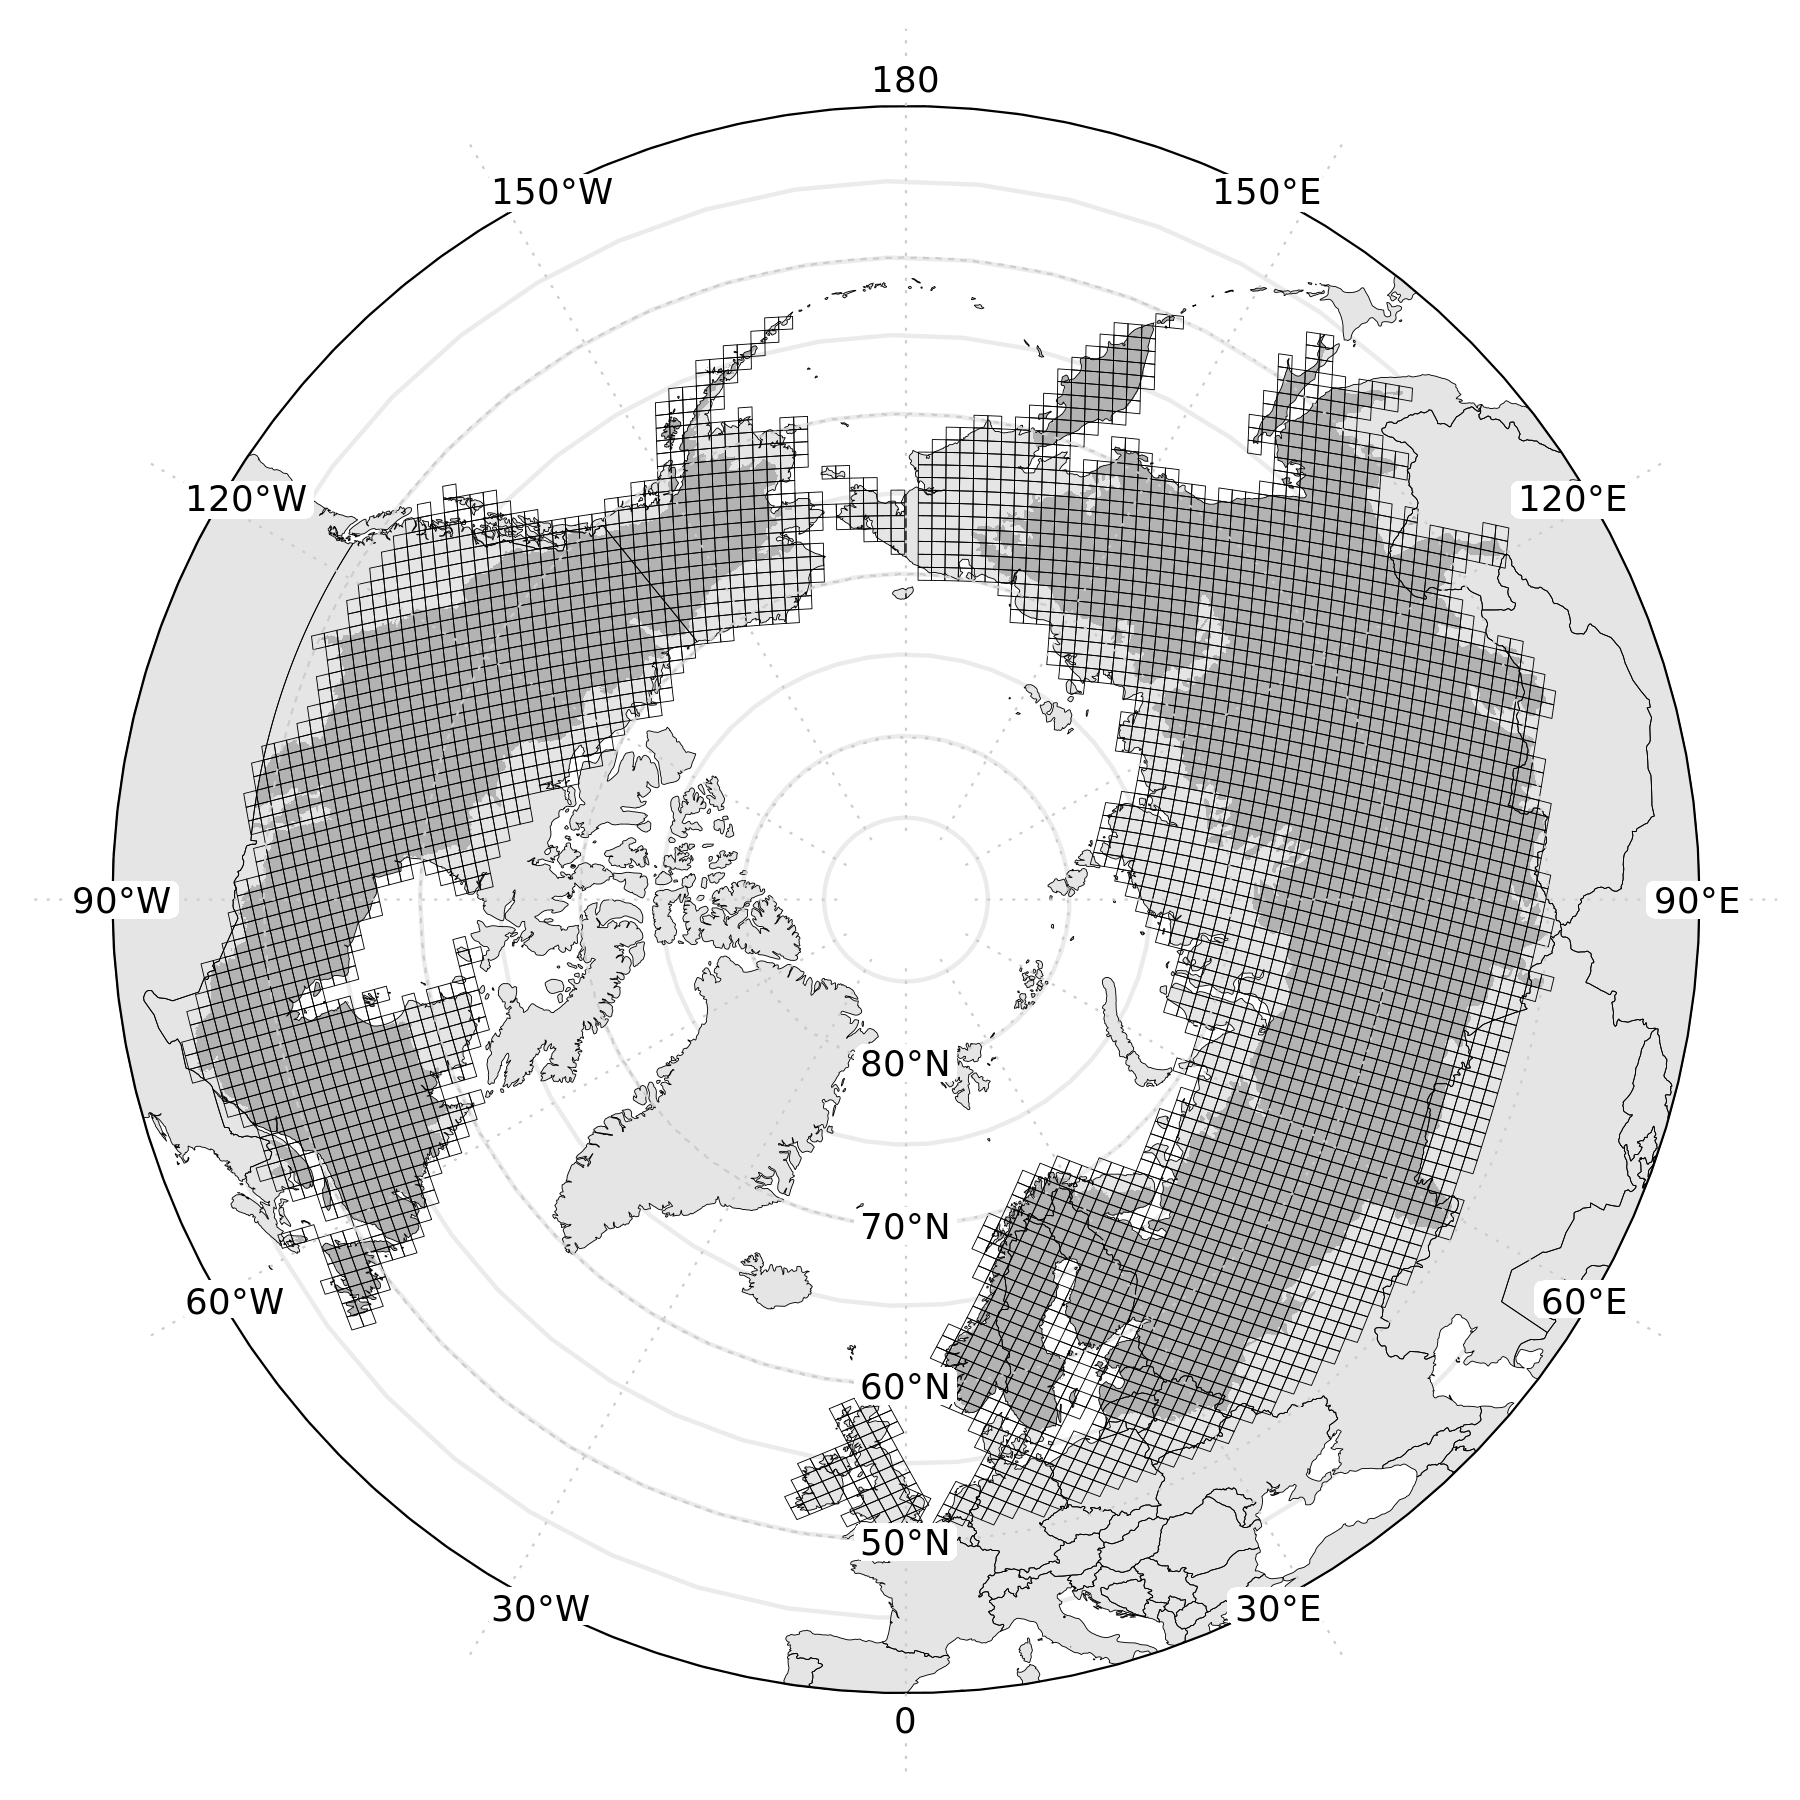

In [51]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 300)

m_boreal_tiles = DO_MAP_BOREAL_SP(MAP_EXTENT=ext,  
                     BOREAL_SHP_FN = wwf_circ_dis_fn,
                     LAYER_LIST = list(geom_polygon(data = boreal_tiles_gcs %>% dplyr::filter(tile_num %in% boreal_tile_num_DAAC_list), 
                                                    aes(x = long, y = lat, group = group), size=0.1, fill=NA, color='black')) #, fill=NA
                    ) + 
    theme(legend.text=element_text(size=rel(0.5))) #+
    #scale_color_brewer(palette = 'Set2') +
    #scale_fill_viridis_d() +
    #guides(fill=guide_legend(title="Tile groups", title.position = "top", label.position = "bottom", keywidth = unit(.5, "cm"), keyheight = unit(.25, "cm"), nrow=2))
m_boreal_tiles

## Export figure: DAAC tiles - all tiles for c2020 map

In [55]:
DATA_NAME_STEM = "boreal_tiles_DAAC"
EXPORT_TIME_STR = format(Sys.time(), "_%Y%m%d")

for(OUT_TYPE in c('png', 'pdf')){
    map_fn = path(OUT_FIGURE_DIR, paste0("map_",DATA_NAME_STEM,"_", EXPORT_TIME_STR,".", OUT_TYPE))
    print(map_fn)
    ggsave(plot = m_boreal_tiles,
           file = map_fn,
           device = OUT_TYPE, dpi = 300, width = 8, height = 15)
}

/projects/my-public-bucket/boreal_polar_map/paper_figs/map_boreal_tiles_DAAC__20230706.png
/projects/my-public-bucket/boreal_polar_map/paper_figs/map_boreal_tiles_DAAC__20230706.pdf


## Map HLS metadata

In [62]:
boreal_tiles_hls_metadata_gcs = shp_fort_join('/projects/my-public-bucket/databank/boreal_tiles_mscomp_c2020_hls_metadata.gpkg', ext, REPROJECT=TRUE)

OGR data source with driver: GPKG 
Source: "/projects/my-public-bucket/databank/boreal_tiles_mscomp_c2020_hls_metadata.gpkg", layer: "boreal_tiles_mscomp_c2020_hls_metadata"
with 3891 features
It has 4 fields
Integer64 fields read as strings:  tile_num HLS_scenes_count properties.eo:cloud_cover_max 


Regions defined for each Polygons



In [63]:
head(boreal_tiles_hls_metadata_gcs %>% as.data.frame())

long      lat      order hole  piece id group tile_num HLS_scenes_count
1 -78.32779 51.07725 1     FALSE 1     1  1.1   1326     40              
2 -78.40291 51.88216 2     FALSE 1     1  1.1   1326     40              
3 -77.09133 51.92131 3     FALSE 1     1  1.1   1326     40              
4 -77.04127 51.11572 4     FALSE 1     1  1.1   1326     40              
5 -78.32779 51.07725 5     FALSE 1     1  1.1   1326     40              
6 -77.04127 51.11572 1     FALSE 1     2  2.1   1265     55              
  properties.eo.cloud_cover_mean properties.eo.cloud_cover_max
1 6.500000                       25                           
2 6.500000                       25                           
3 6.500000                       25                           
4 6.500000                       25                           
5 6.500000                       25                           
6 8.945455                       35

OGR data source with driver: GeoJSON 
Source: "/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson", layer: "wwf_circumboreal_Dissolve"
with 2 features
It has 4 fields


Regions defined for each Polygons

Regions defined for each Polygons

Regions defined for each Polygons



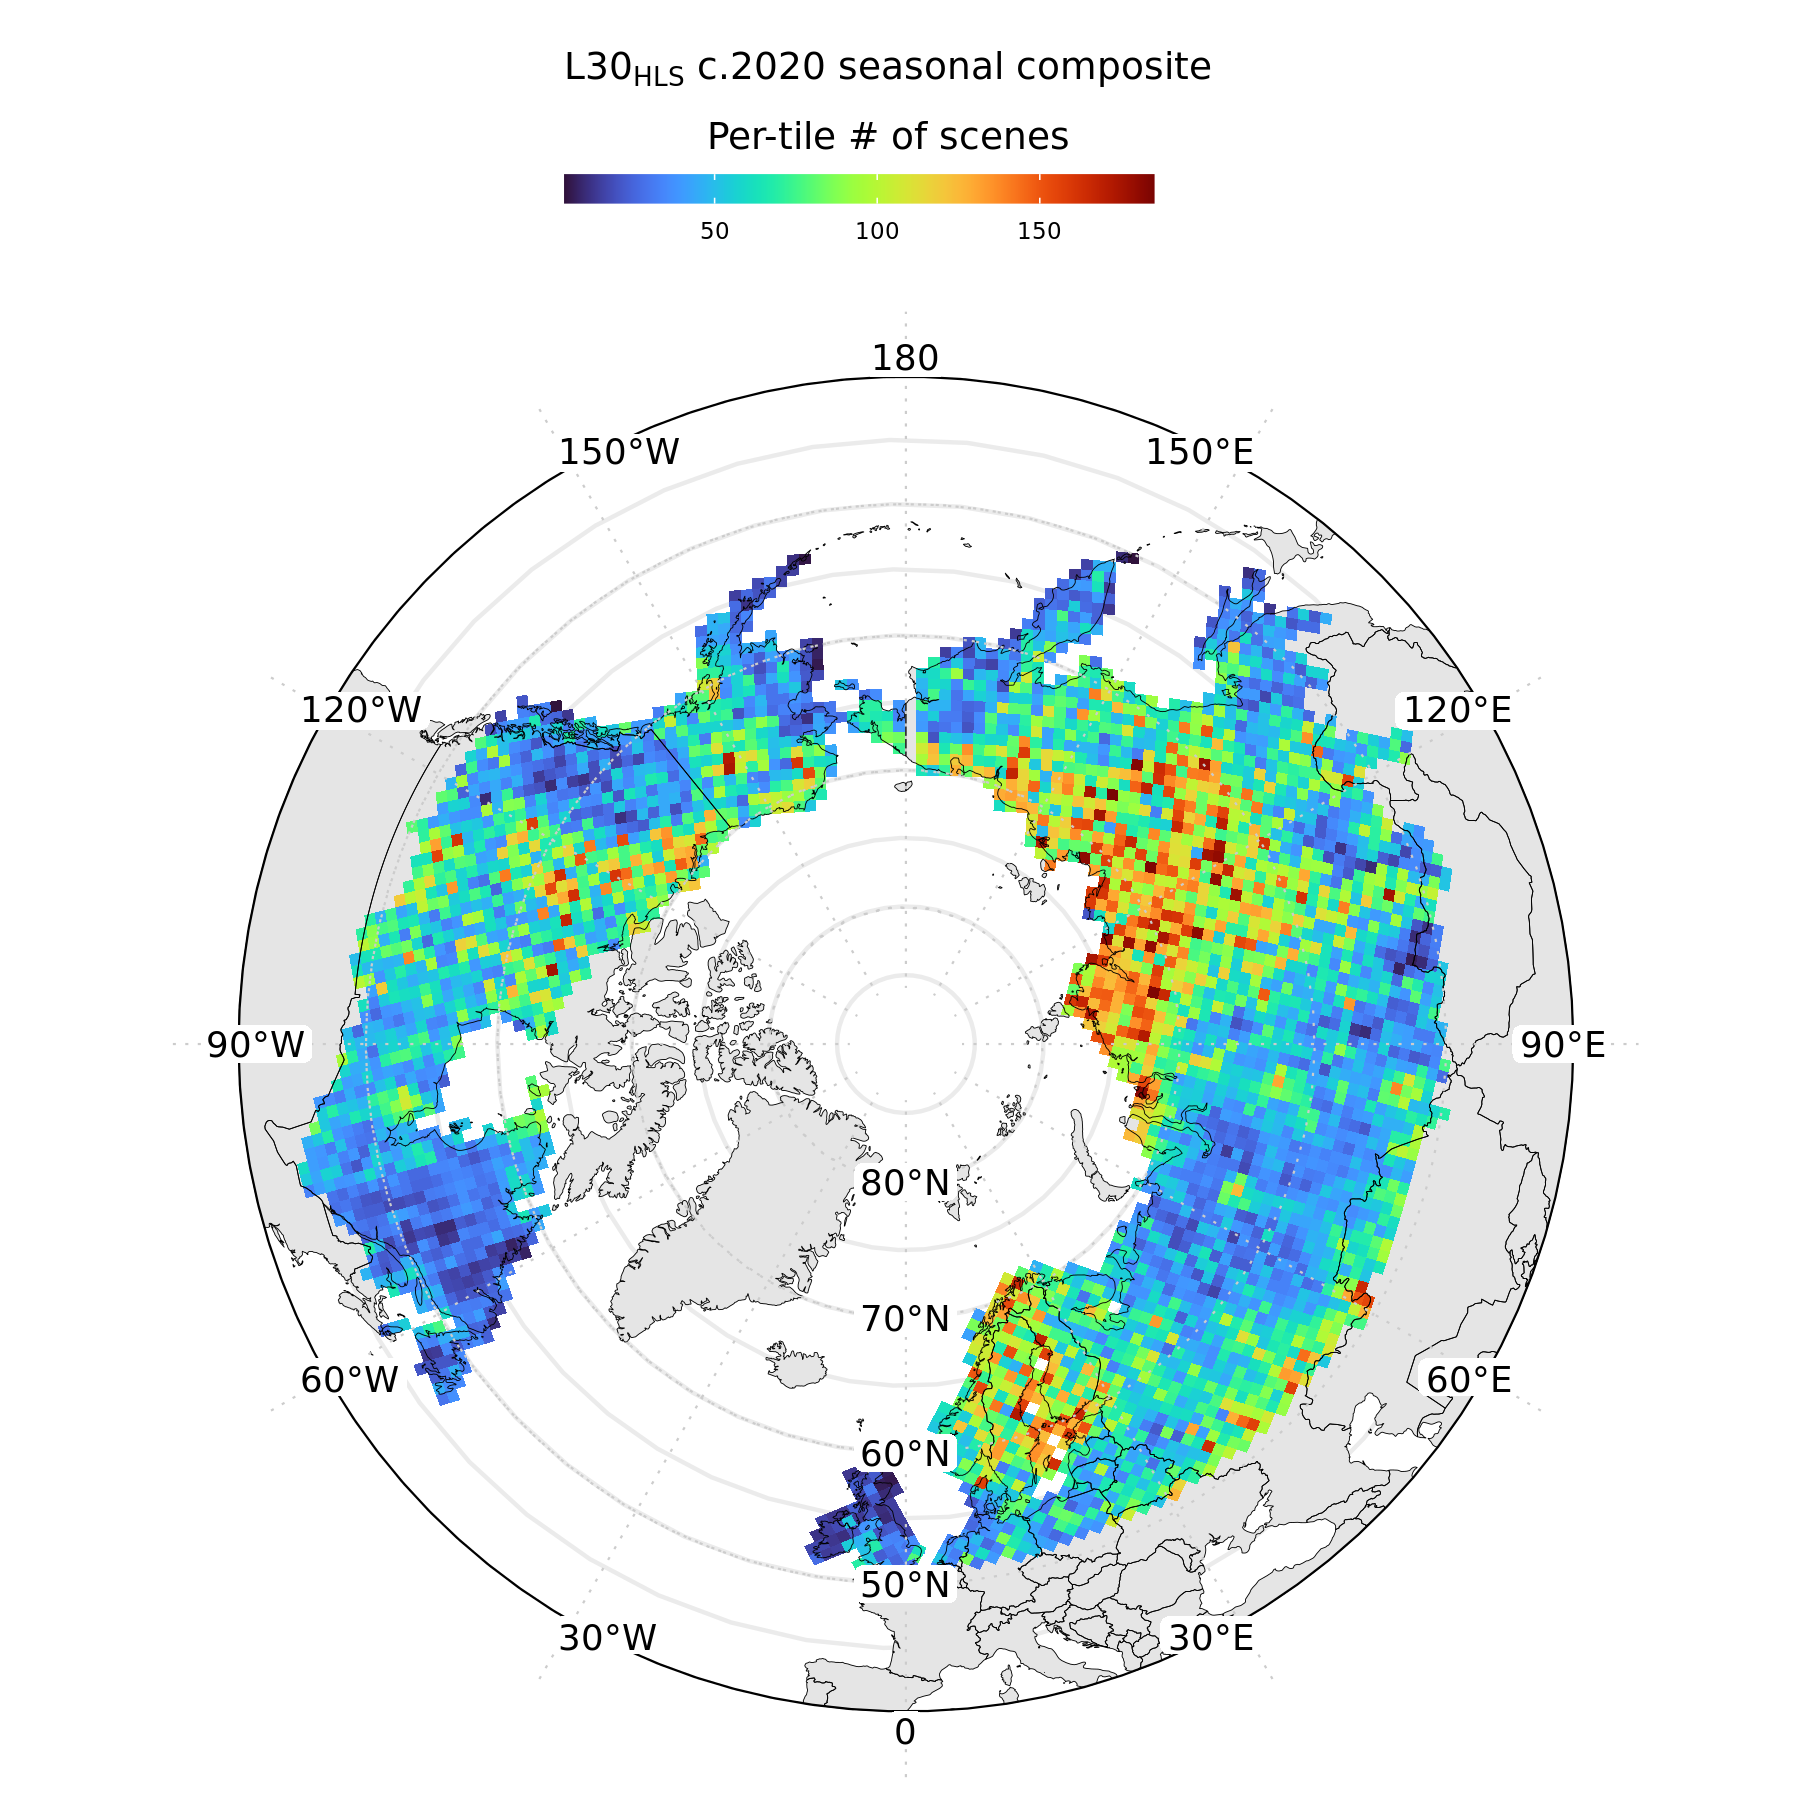

In [126]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 300)

m_boreal_tiles_HLS = DO_MAP_BOREAL_SP(MAP_EXTENT=ext,  
                     BOREAL_SHP_FN = wwf_circ_dis_fn,
                     LAYER_LIST = list(geom_polygon(data = boreal_tiles_hls_metadata_gcs %>% dplyr::filter(tile_num %in% boreal_tile_num_DAAC_list), 
                                                    aes(x = long, y = lat, group = group, fill=as.integer(HLS_scenes_count)), size=0.1)) #, fill=NA
                    ) + 
    theme(legend.text=element_text(size=rel(0.5))) +
    #scale_fill_brewer(palette = 'Set2') +

    guides(fill=guide_colourbar(title=expression(atop(L30[HLS]~"c.2020 seasonal composite","Per-tile # of scenes")), title.position = "top", label.position = "bottom", keywidth = unit(.5, "cm"), keyheight = unit(.25, "cm"), nrow=1))+
    scale_fill_viridis(option = 'turbo')
m_boreal_tiles_HLS

## Export figure: DAAC tiles - num scenes for c2020 composite

In [91]:
DATA_NAME_STEM = "boreal_tiles_DAAC_num_HLS_scenes"
EXPORT_TIME_STR = format(Sys.time(), "_%Y%m%d")

for(OUT_TYPE in c('png', 'pdf')){
    map_fn = path(OUT_FIGURE_DIR, paste0("map_",DATA_NAME_STEM,"_", EXPORT_TIME_STR,".", OUT_TYPE))
    print(map_fn)
    ggsave(plot = m_boreal_tiles_HLS,
           file = map_fn,
           device = OUT_TYPE, dpi = 300, width = 8, height = 15)
}

/projects/my-public-bucket/boreal_polar_map/paper_figs/map_boreal_tiles_DAAC_num_HLS_scenes__20230706.png
/projects/my-public-bucket/boreal_polar_map/paper_figs/map_boreal_tiles_DAAC_num_HLS_scenes__20230706.pdf


## Map HLS compositing params

In [73]:
# #hls_params = read.csv("/projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS_test_redo/spring2022/HLS_input_params.csv")
#hls_params_fn = read.csv("/projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_input_params.csv")

# This is the final list of HLS tiles that include the fixed (45) tiles
Sys.setenv("AWS_DEFAULT_REGION" = "us-west-2") 
# Read rom s3
hls_params <- aws.s3::s3read_using(read.csv, object = hls_params_fn)

boreal_tiles_gcs_HLS = boreal_tiles_gcs %>% 
    dplyr::mutate(tile_num = as.numeric(tile_num)) %>% 
    dplyr::left_join(hls_params, by = c('tile_num' = 'tile_num')) %>%
    unite(HLS_run_name, c("max_cloud","start_month_day","end_month_day"),sep = "\n", remove = FALSE)

OGR data source with driver: GeoJSON 
Source: "/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson", layer: "wwf_circumboreal_Dissolve"
with 2 features
It has 4 fields


Regions defined for each Polygons

Regions defined for each Polygons

Regions defined for each Polygons



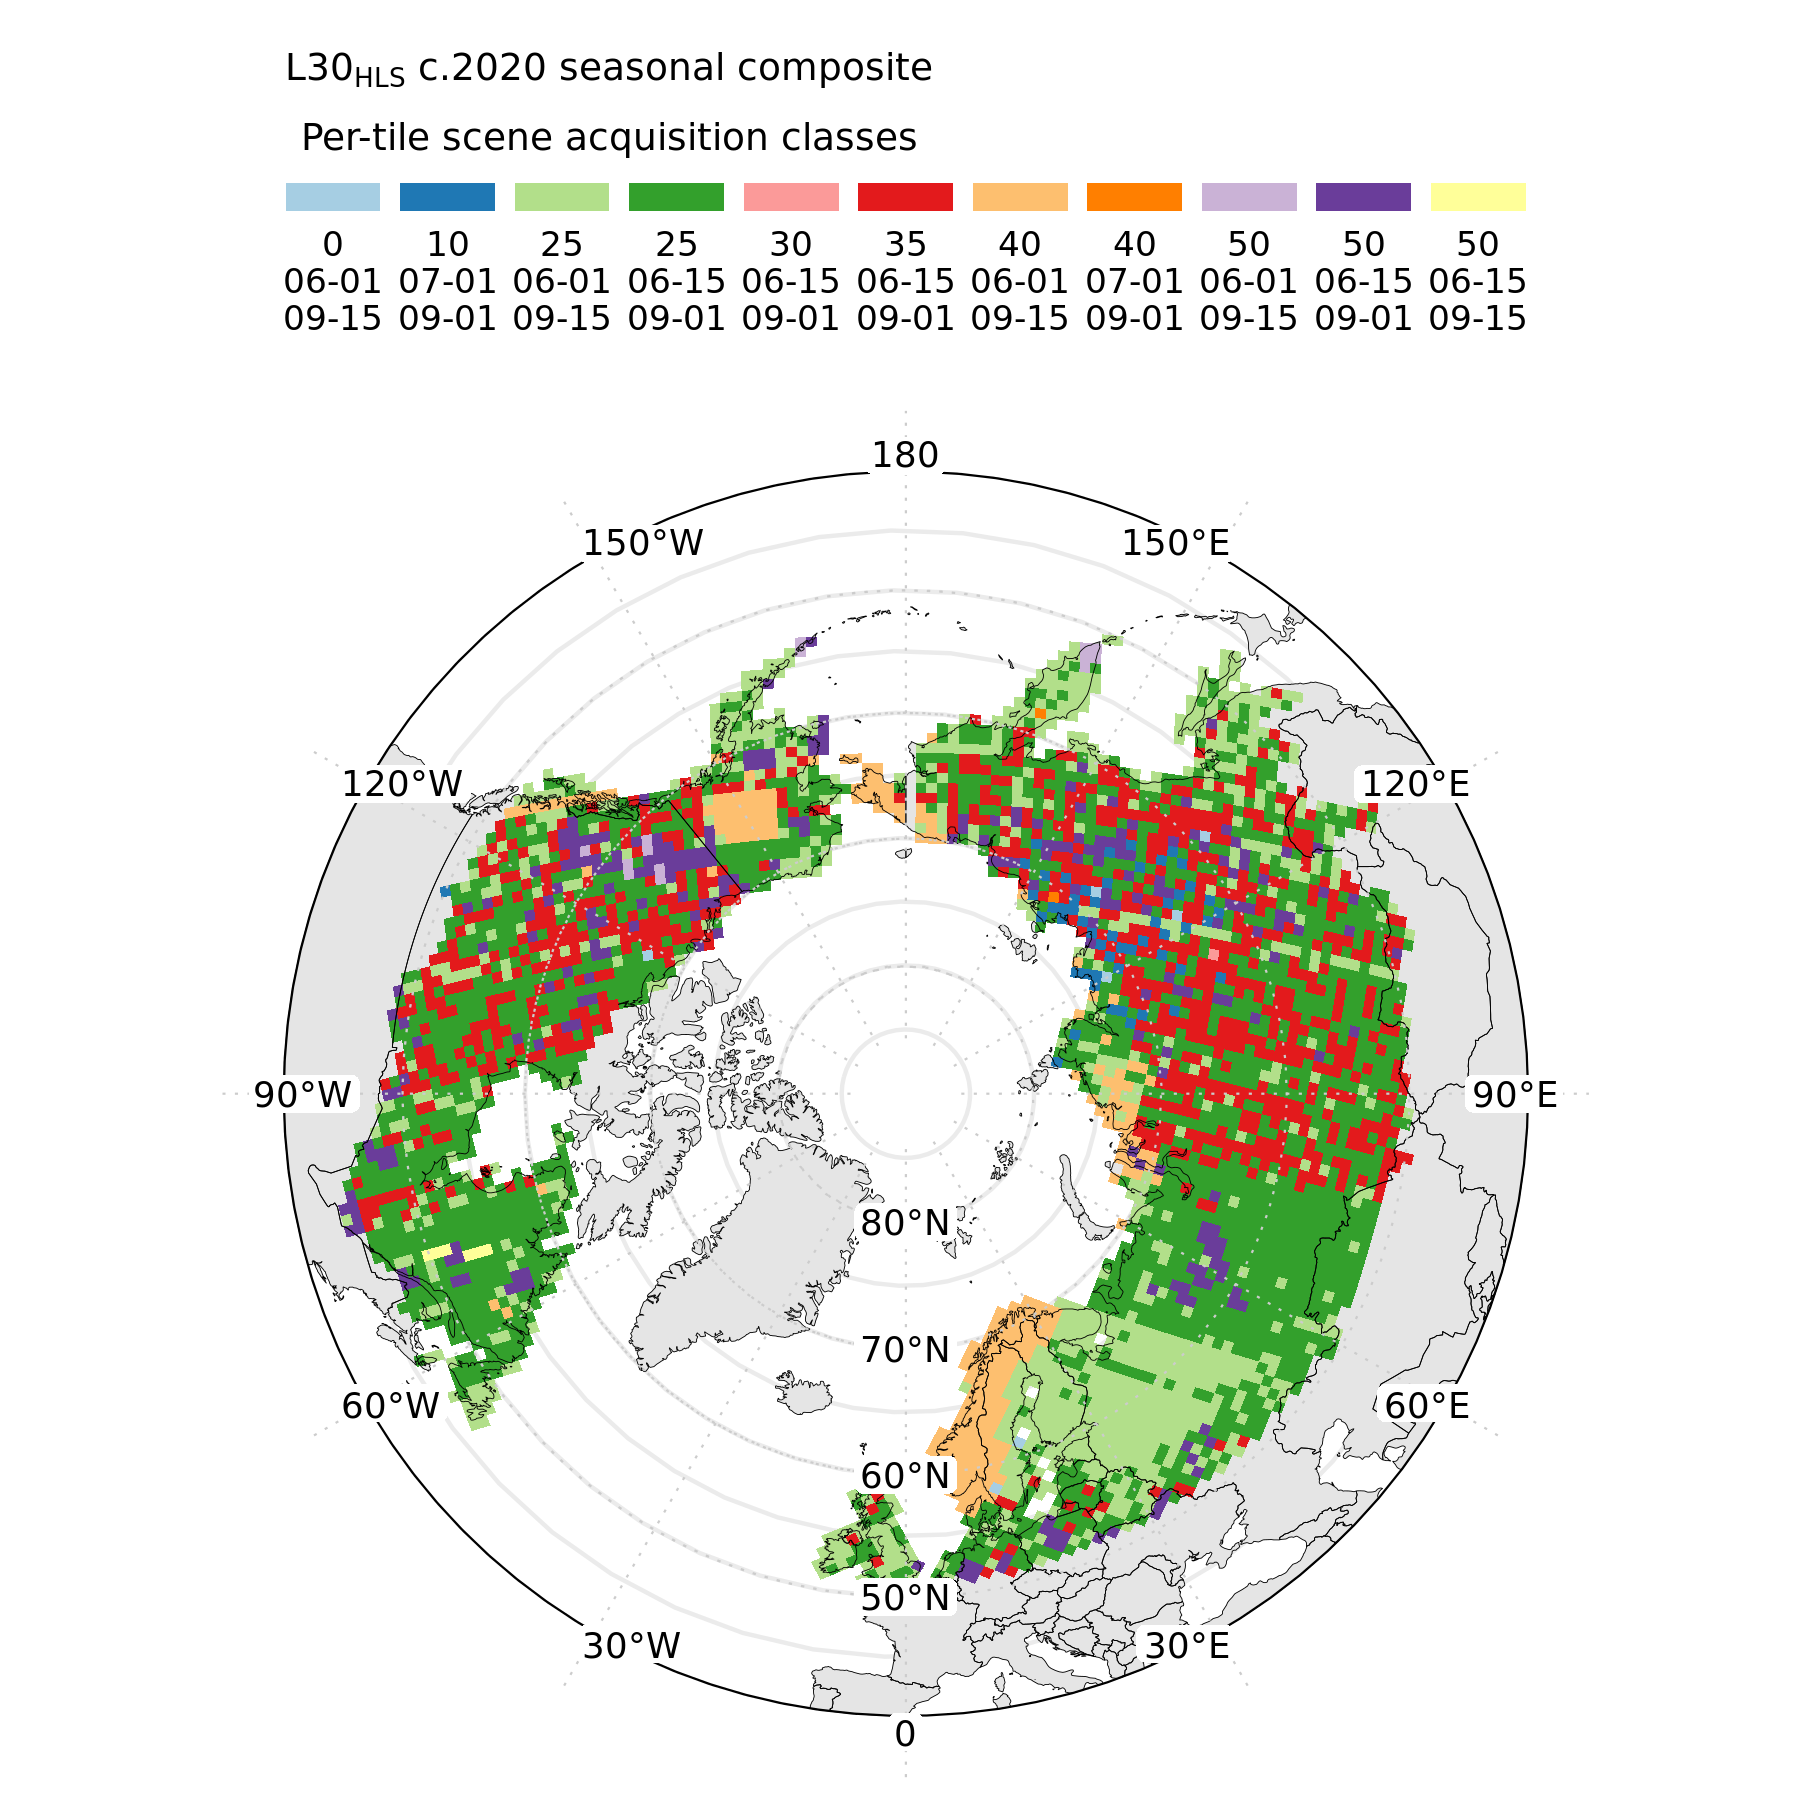

In [125]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 300)
# Show map of HLS compositing params

m_hls_runname = DO_MAP_BOREAL_SP(MAP_EXTENT=ext,  
                     BOREAL_SHP_FN = wwf_circ_dis_fn,
                     LAYER_LIST = list(geom_polygon(data = boreal_tiles_gcs_HLS %>% dplyr::filter(tile_num %in% boreal_tile_num_DAAC_list), 
                                                    aes(x = long, y = lat, group = group, fill=HLS_run_name), size=0.1)
                                      
                                      )
                    ) + 
    theme(legend.text=element_text(size=rel(0.75))) +
    guides(fill=guide_legend(
                            #title=expression(L30[HLS]~"c.2020 seasonal composite\nscene acquisition classes"), 
                            title=expression(atop(L30[HLS]~"c.2020 seasonal composite","Per-tile scene acquisition classes")), 
                             title.position = "top", label.position = "bottom", keywidth = unit(.5, "cm"), keyheight = unit(.25, "cm"), nrow=1))+
    #scale_fill_manual(values= c(wes_palette("Zissou1", n = 5), wes_palette("Darjeeling1", n = 5))) 
    scale_fill_brewer(palette='Paired')

m_hls_runname

In [130]:
DATA_NAME_STEM = "boreal_tiles_DAAC_HLS_comp_multiplot"
EXPORT_TIME_STR = format(Sys.time(), "_%Y%m%d")

for(OUT_TYPE in c('png', 'pdf')){
    map_fn = path(OUT_FIGURE_DIR, paste0("map_",DATA_NAME_STEM,"_", EXPORT_TIME_STR,".", OUT_TYPE))
    print(map_fn)
    ggsave(plot = m_hls_multiplot,
           file = map_fn,
           device = OUT_TYPE, dpi = 300, width = 15, height = 8)
}

/projects/my-public-bucket/boreal_polar_map/paper_figs/map_boreal_tiles_DAAC_HLS_comp_multiplot__20230706.png
/projects/my-public-bucket/boreal_polar_map/paper_figs/map_boreal_tiles_DAAC_HLS_comp_multiplot__20230706.pdf


### Get from mscomp_metadata_gdf.ipynb

In [135]:
df_scenes = read_csv('/projects/my-public-bucket/boreal_polar_map/tables/mscomp_hls_scenes_smry.csv')
head(df_scenes)

Rows: 84209 Columns: 9

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): id, start, end, HLS_type
dbl (5): count, properties.eo:cloud_cover, year, month, doy


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



id                                 count properties.eo:cloud_cover year start
1 HLS.L30.T01VCK.2020208T232307.v2.0 1     11                        2020 07-01
2 HLS.L30.T01VCK.2020224T232310.v2.0 1     29                        2020 07-01
3 HLS.L30.T01VCK.2021194T232306.v2.0 1     33                        2021 07-01
4 HLS.L30.T01VCL.2019230T231710.v2.0 2     37                        2019 07-01
5 HLS.L30.T01VCL.2019237T232259.v2.0 3      5                        2019 07-01
6 HLS.L30.T01VCL.2020208T232244.v2.0 3      6                        2020 07-01
  end   HLS_type month doy
1 09-01 L30      7     208
2 09-01 L30      8     224
3 09-01 L30      7     194
4 09-01 L30      8     230
5 09-01 L30      8     237
6 09-01 L30      7     208

/projects/my-public-bucket/boreal_polar_map/paper_figs/plot_mscomp_HLS_num_scenes_hist__20230706.png


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



/projects/my-public-bucket/boreal_polar_map/paper_figs/plot_mscomp_HLS_num_scenes_hist__20230706.pdf


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



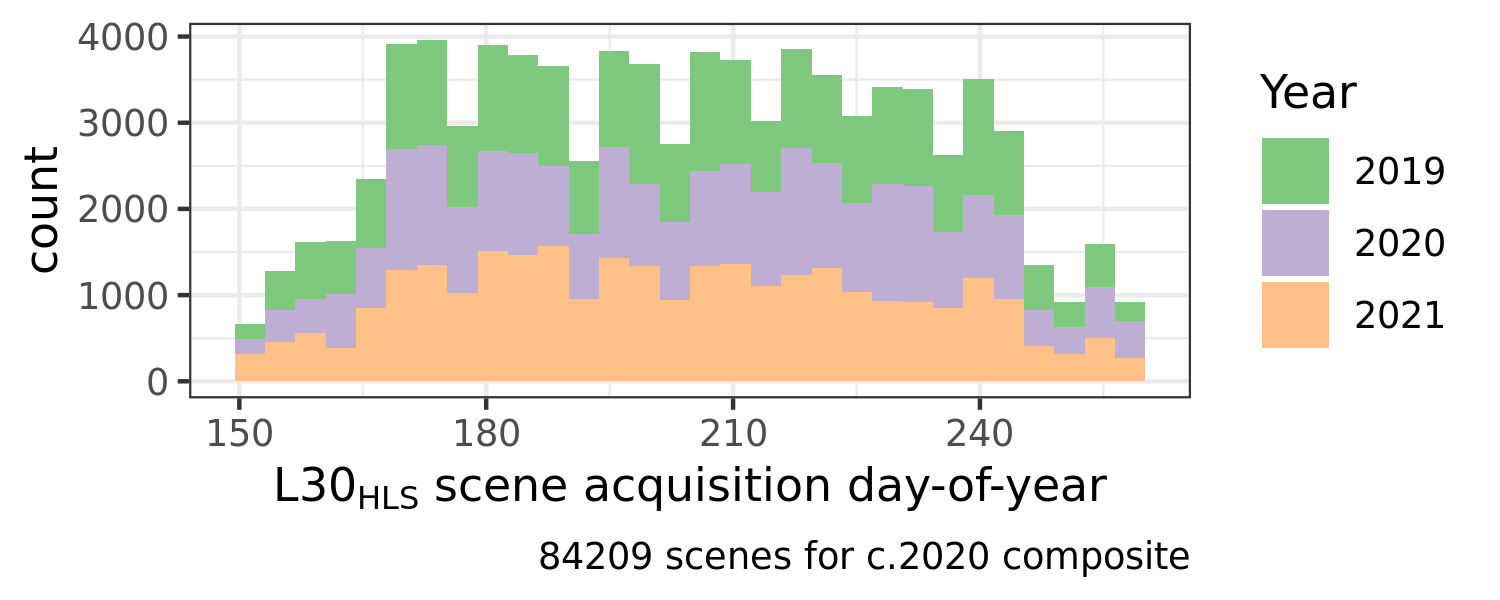

In [159]:
options(repr.plot.height = 2, repr.plot.width = 5, warn=-1)
p_doy_hist = ggplot(data = df_scenes) +
    geom_histogram(aes(x=doy, fill=as.factor(year)), position = position_stack() ) +
    #facet_grid('~year') +
    scale_fill_brewer(palette=1, type='qual') +
    labs(x=expression(L30[HLS]~"scene acquisition day-of-year"), fill='Year', caption=paste0(nrow(df_scenes), " scenes for c.2020 composite")) +
    theme_bw()

DATA_NAME_STEM = "mscomp_HLS_num_scenes_hist"
EXPORT_TIME_STR = format(Sys.time(), "_%Y%m%d")

for(OUT_TYPE in c('png', 'pdf')){
    map_fn = path(OUT_FIGURE_DIR, paste0("plot_",DATA_NAME_STEM,"_", EXPORT_TIME_STR,".", OUT_TYPE))
    print(map_fn)
    ggsave(plot = p_doy_hist,
           file = map_fn,
           device = OUT_TYPE, dpi = 150, width = 5, height = 2)
}

p_doy_hist

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



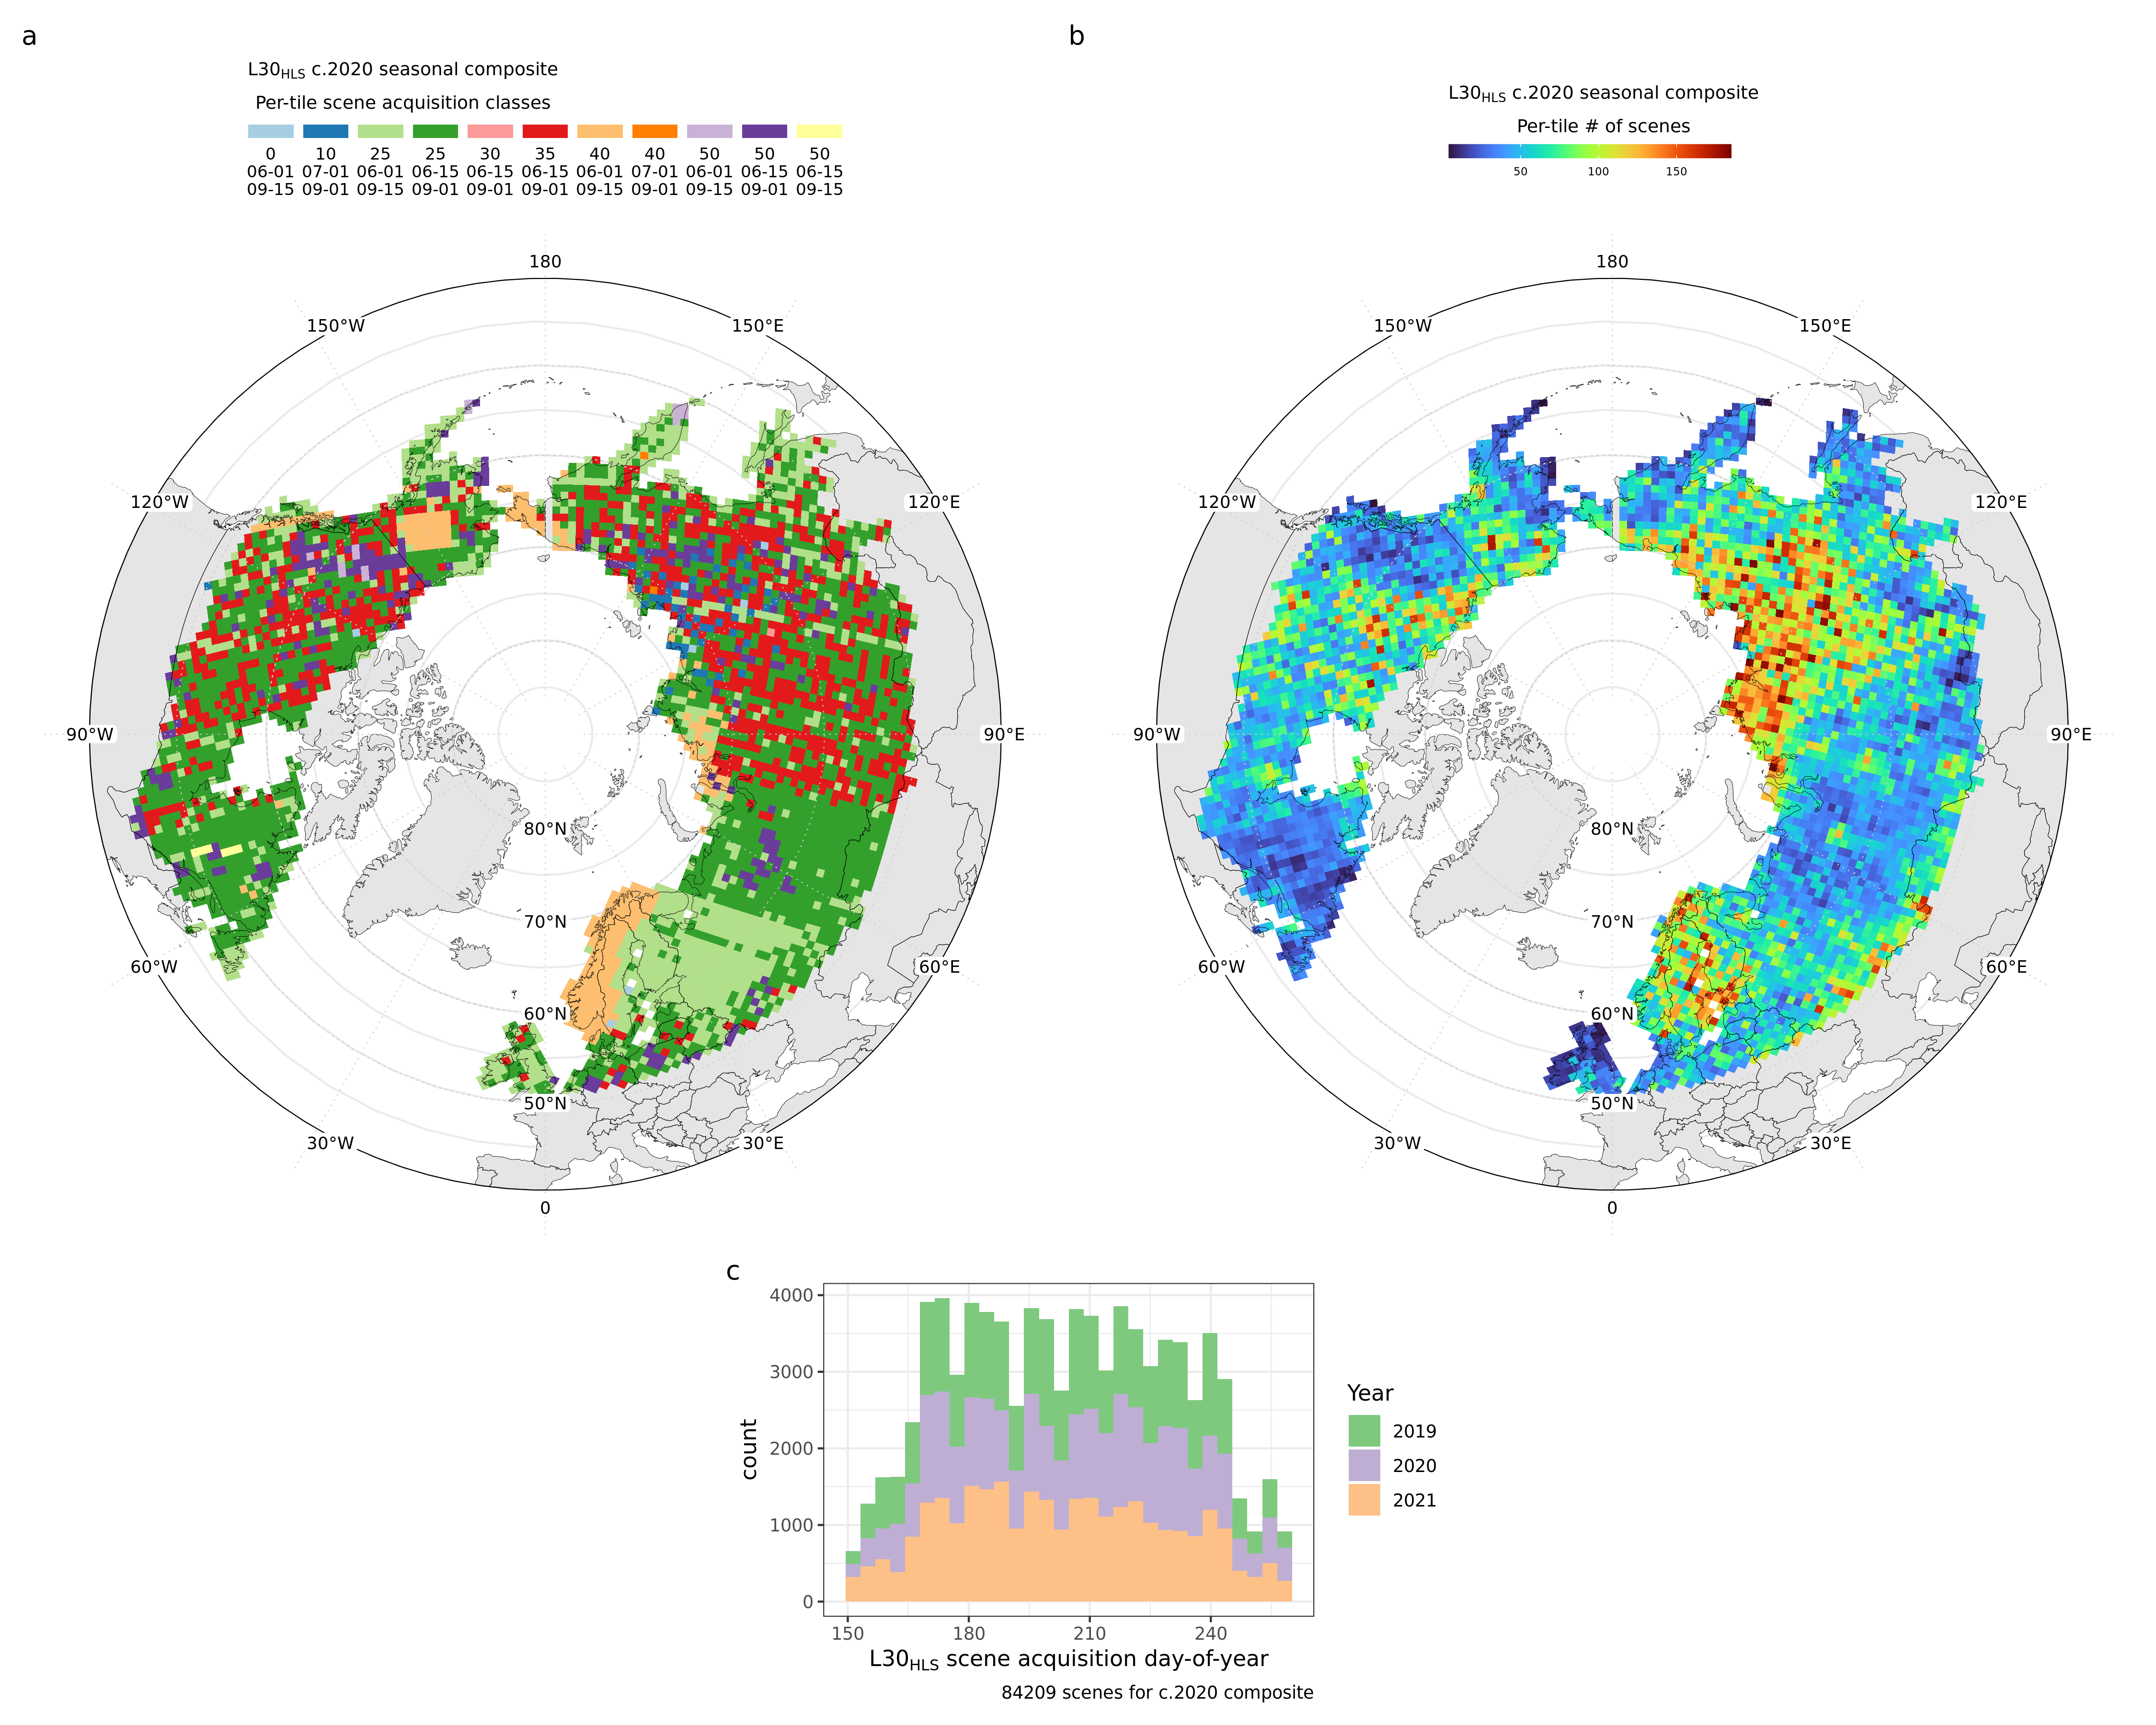

In [173]:
options(repr.plot.height = 12, repr.plot.width = 15, warn=-1)

layout = "
AAAABBBB
AAAABBBB
AAAABBBB
###CC###
"

m_hls_multiplot = m_hls_runname + m_boreal_tiles_HLS + p_doy_hist +
    plot_layout(design = layout) +
    plot_annotation(tag_levels = 'a') #+ theme(plot.tag = element_text(size = 26))

m_hls_multiplot

## Export figure: DAAC tiles - multiplot for c2020 composite

In [174]:
DATA_NAME_STEM = "boreal_tiles_DAAC_HLS_comp_multiplot"
EXPORT_TIME_STR = format(Sys.time(), "_%Y%m%d")

for(OUT_TYPE in c('png', 'pdf')){
    map_fn = path(OUT_FIGURE_DIR, paste0("map_",DATA_NAME_STEM,"_", EXPORT_TIME_STR,".", OUT_TYPE))
    print(map_fn)
    ggsave(plot = m_hls_multiplot,
           file = map_fn,
           device = OUT_TYPE, dpi = 300, width = 15, height = 12)
}

/projects/my-public-bucket/boreal_polar_map/paper_figs/map_boreal_tiles_DAAC_HLS_comp_multiplot__20230706.png


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



/projects/my-public-bucket/boreal_polar_map/paper_figs/map_boreal_tiles_DAAC_HLS_comp_multiplot__20230706.pdf


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



In [88]:
m_hls_maxcloud = DO_MAP_BOREAL_SP(MAP_EXTENT=ext,  
                     BOREAL_SHP_FN = wwf_circ_dis_fn,
                     LAYER_LIST = list(geom_polygon(data = boreal_tiles_gcs_HLS %>% dplyr::filter(tile_num %in% boreal_tile_num_DAAC_list), 
                                                    aes(x = long, y = lat, group = group, fill=max_cloud), size=0.1))
                    ) +
    theme(legend.text=element_text(size=rel(0.75))) +
    scale_fill_viridis(option='plasma', direction=-1) +
    guides(fill=guide_colourbar(title=expression("Per-tile scene acquisition cloudcover thresholds (%)"~L30[HLS]~" composite "), title.position = "top", label.position = "bottom", keywidth = unit(.5, "cm"), keyheight = unit(.25, "cm")))


OGR data source with driver: GeoJSON 
Source: "/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson", layer: "wwf_circumboreal_Dissolve"
with 2 features
It has 4 fields


Regions defined for each Polygons

Regions defined for each Polygons

Regions defined for each Polygons



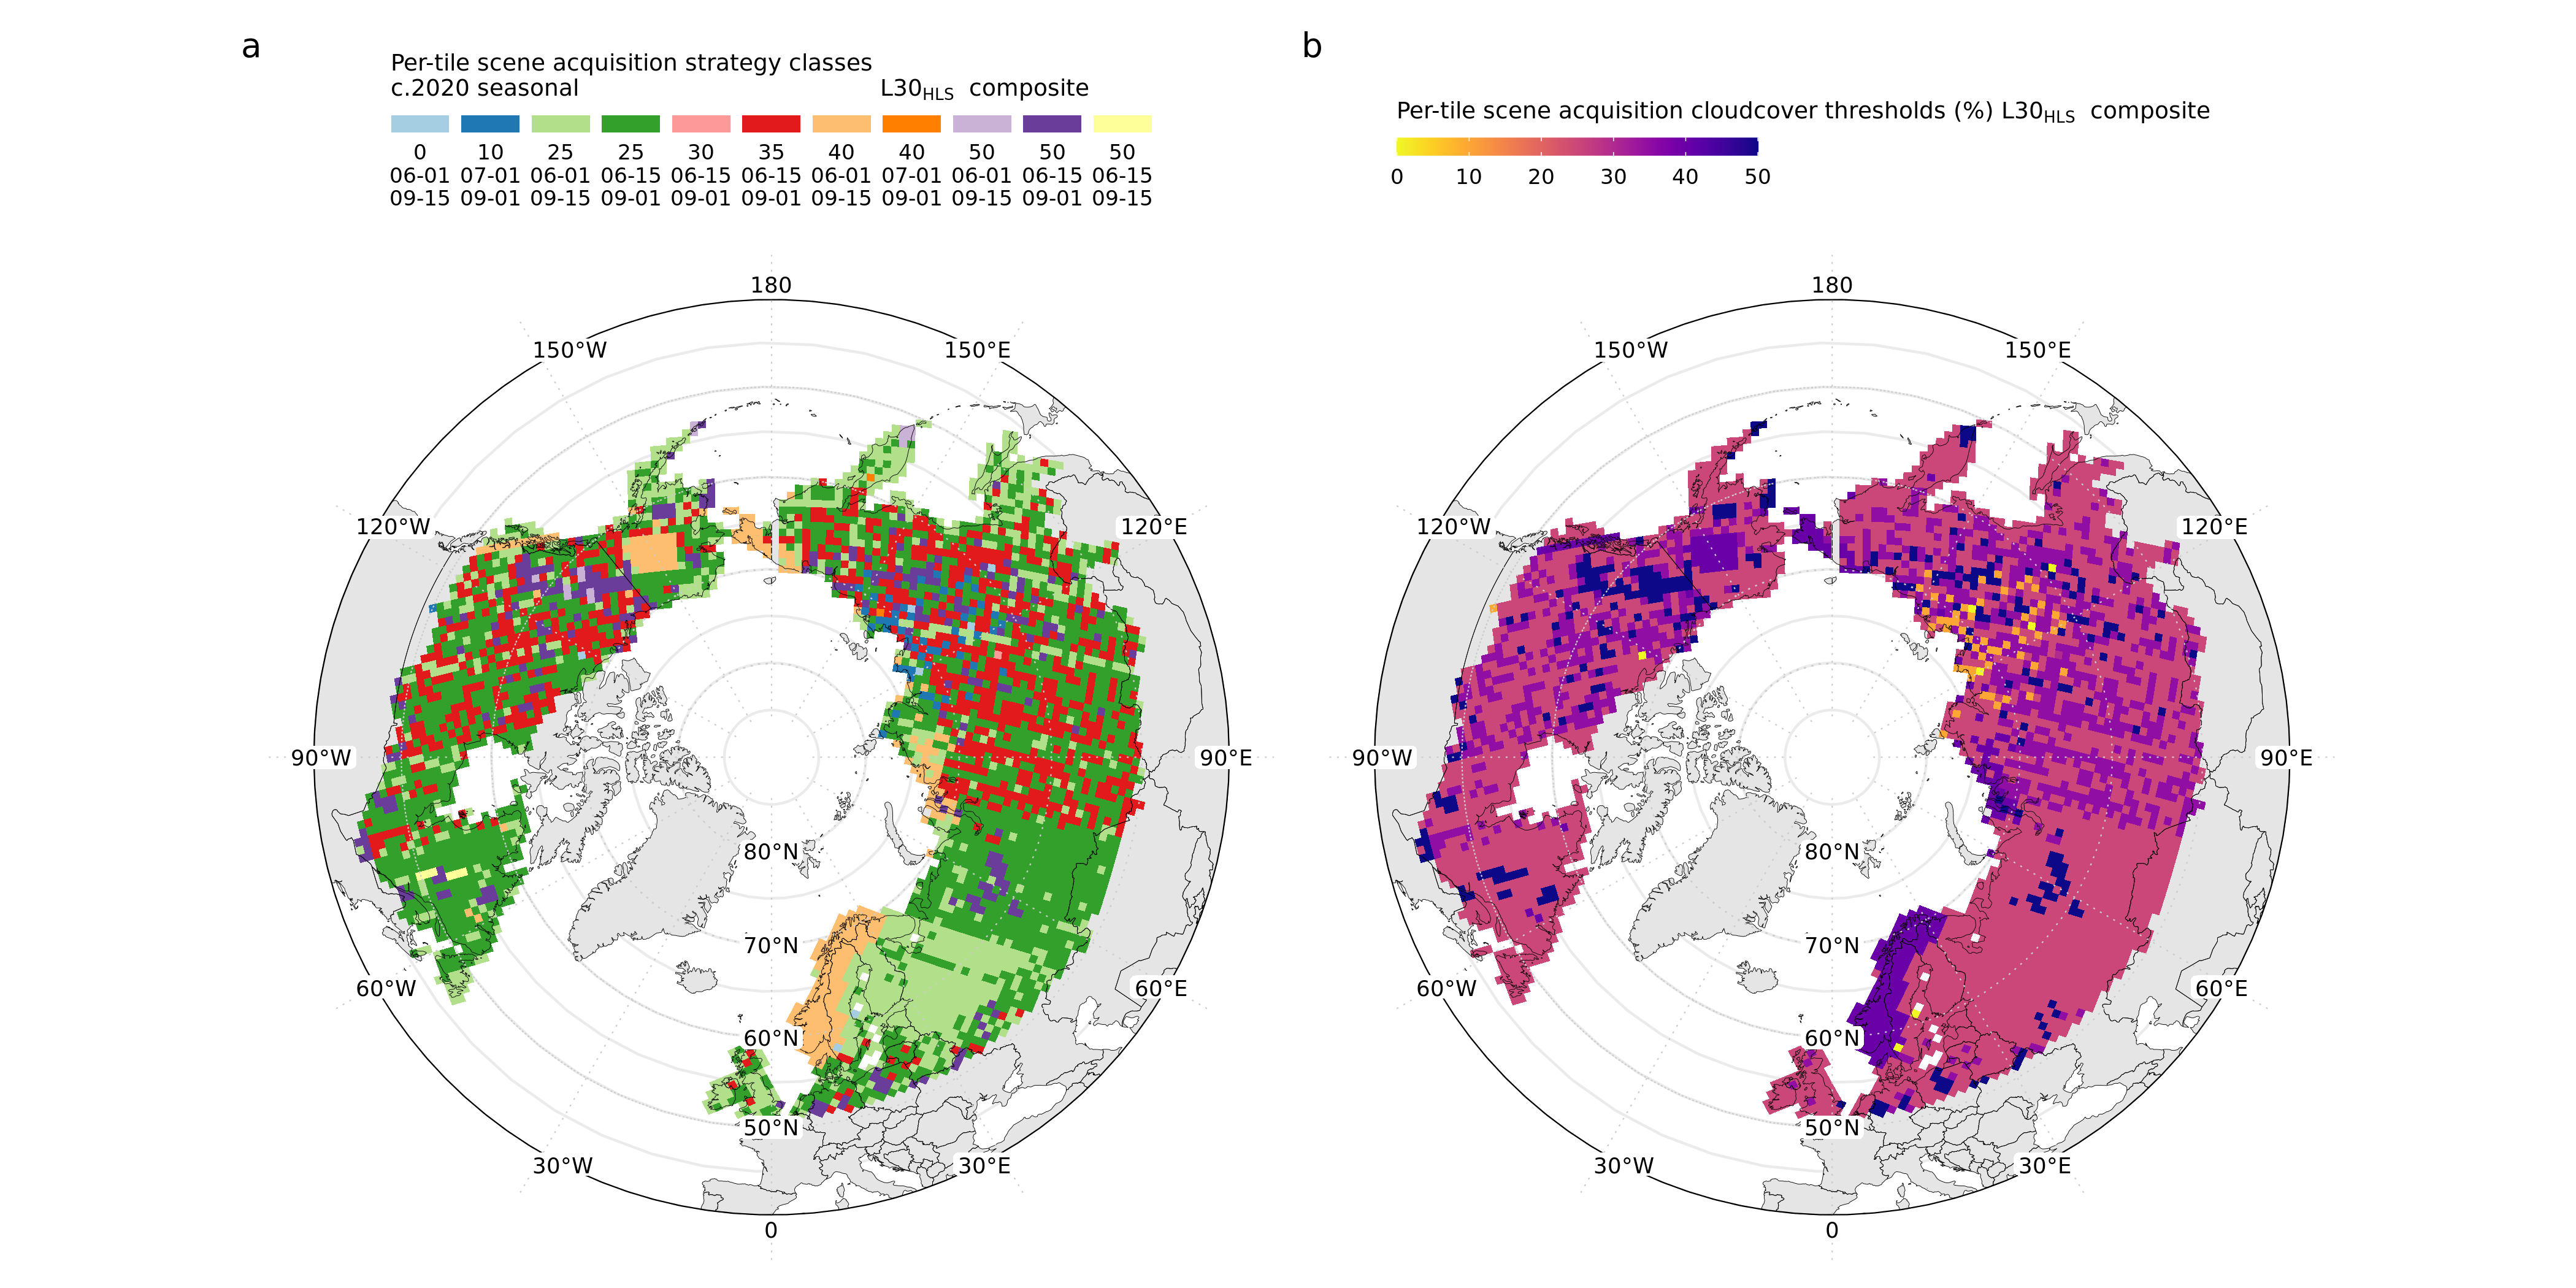

In [89]:
options(repr.plot.height = 7, repr.plot.width = 14, warn=-1)

layout = "
AB
"

m_hls_runname + m_hls_maxcloud +
    plot_layout(design = layout) +
    plot_annotation(tag_levels = 'a') #+ theme(plot.tag = element_text(size = 26))



OGR data source with driver: GeoJSON 
Source: "/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson", layer: "wwf_circumboreal_Dissolve"
with 2 features
It has 4 fields


Regions defined for each Polygons

Regions defined for each Polygons

Regions defined for each Polygons



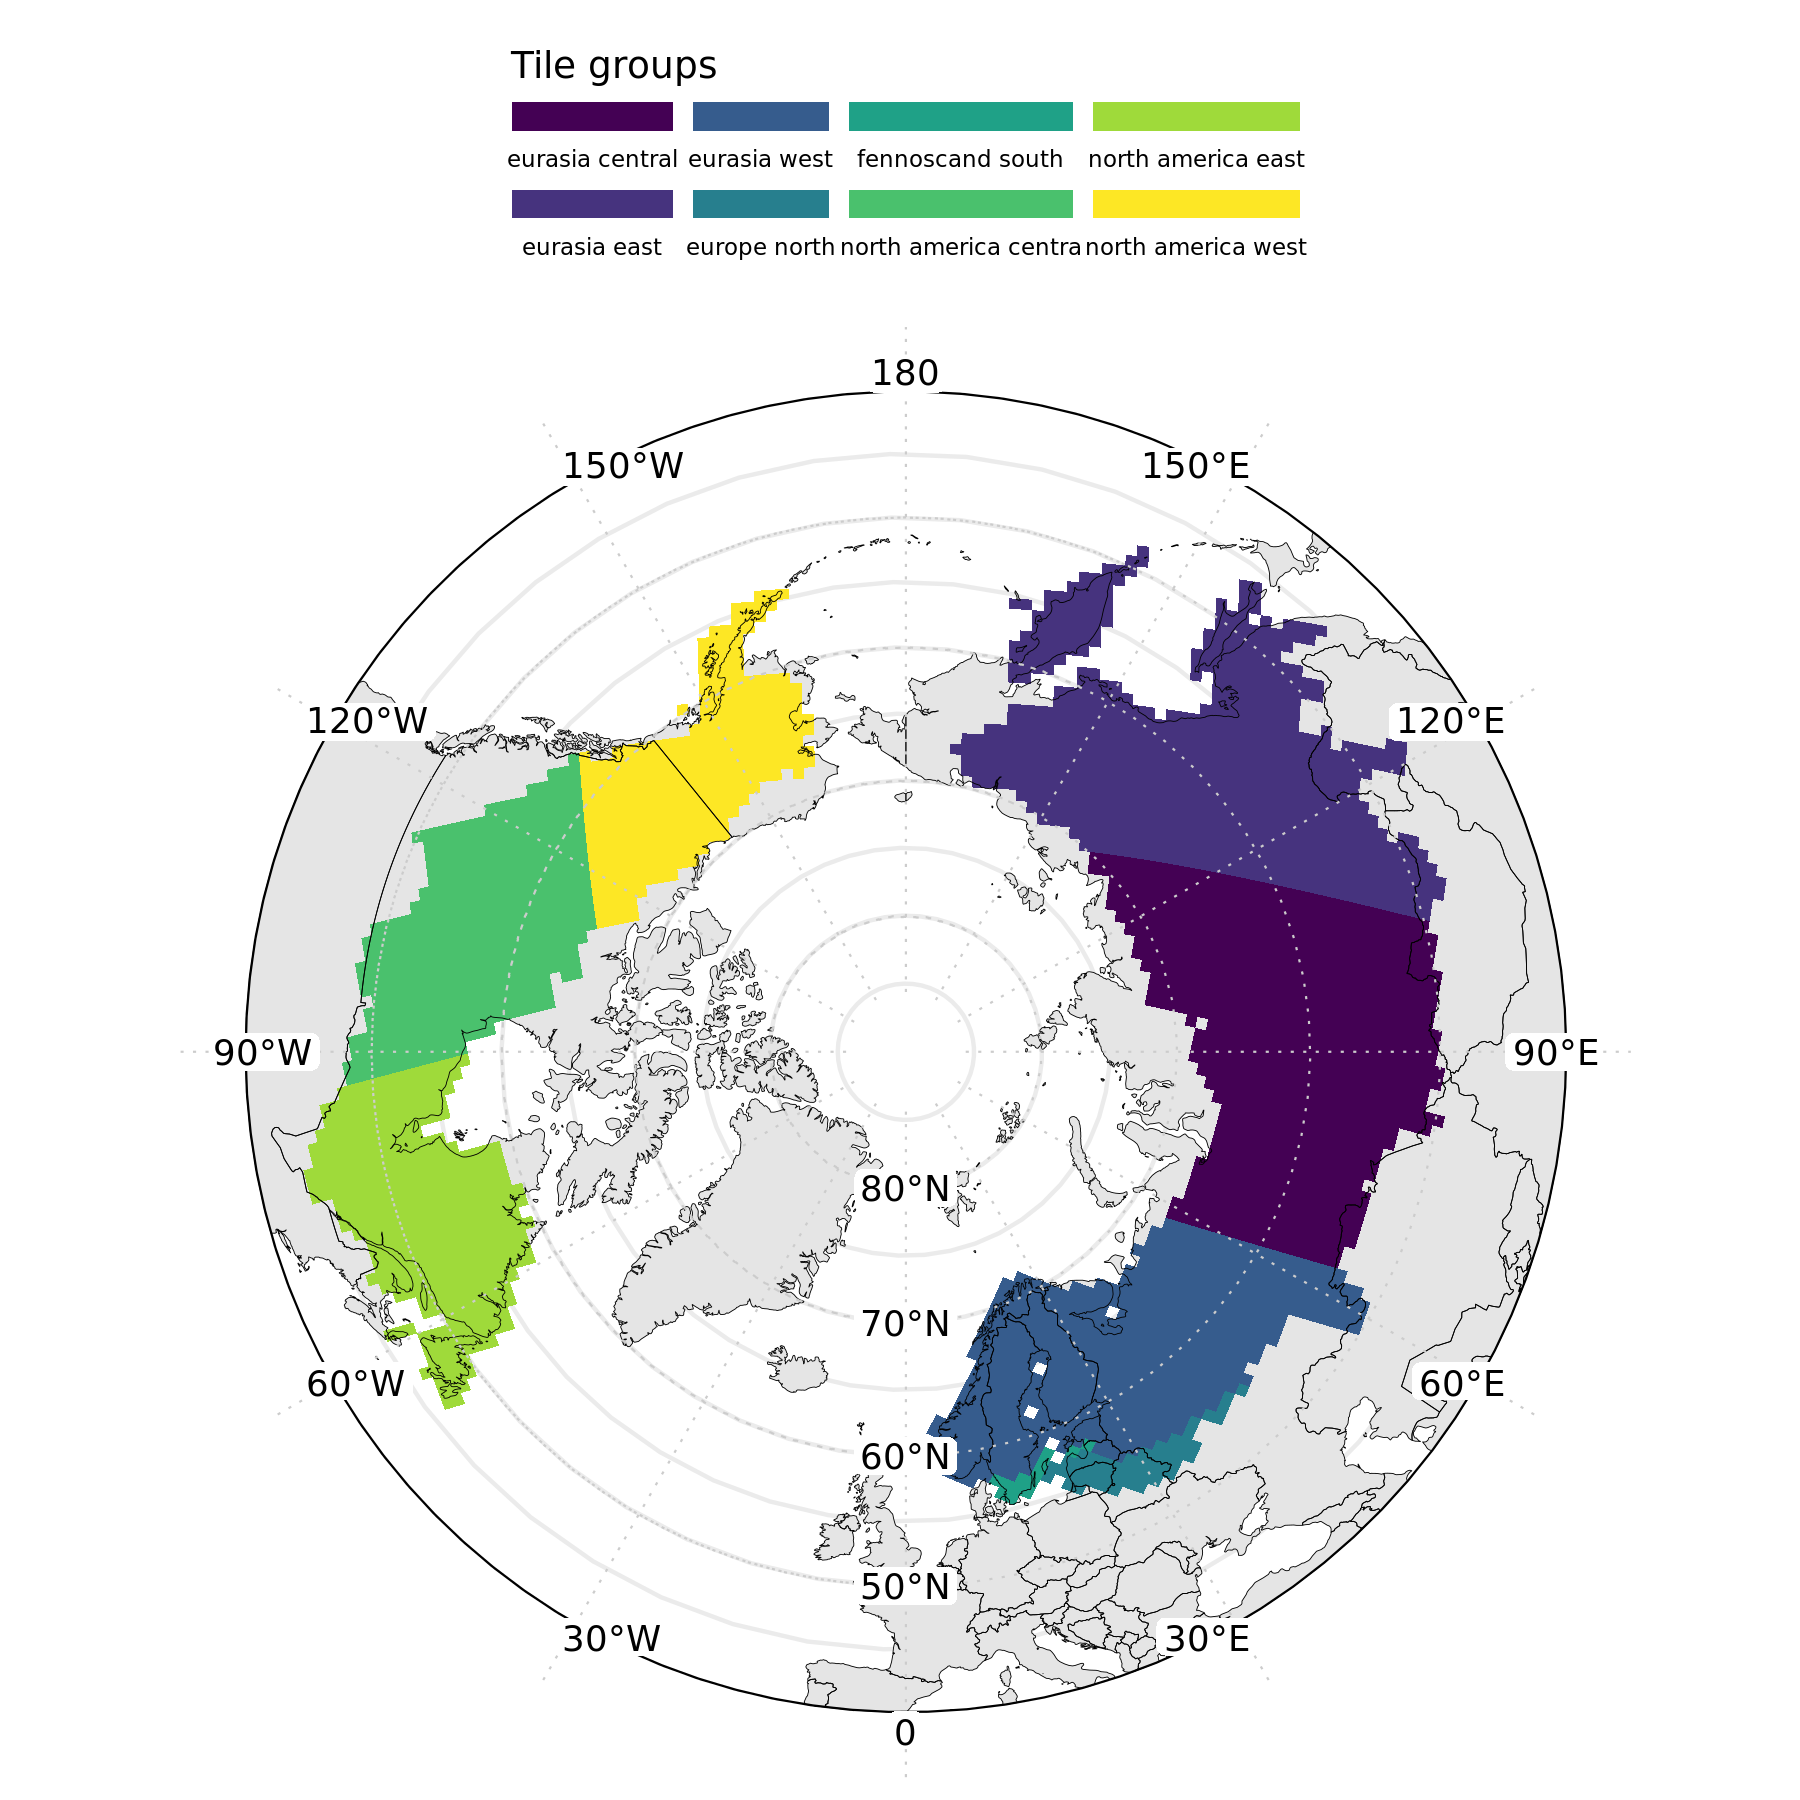

In [17]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 300)

m_groups = DO_MAP_BOREAL_SP(MAP_EXTENT=ext,  
                     BOREAL_SHP_FN = wwf_circ_dis_fn,
                     LAYER_LIST = list(geom_polygon(data = boreal_tiles_gcs %>% dplyr::filter(tile_num %in% boreal_tile_num_list), 
                                                    aes(x = long, y = lat, group = group, fill=tile_group), size=0.1)) #, fill=NA
                    ) + 
    theme(legend.text=element_text(size=rel(0.5))) +
    #scale_color_brewer(palette = 'Set2') +
    scale_fill_viridis_d() +
    guides(fill=guide_legend(title="Tile groups", title.position = "top", label.position = "bottom", keywidth = unit(.5, "cm"), keyheight = unit(.25, "cm"), nrow=2))
m_groups
    


In [68]:
world <- crop(as(ne_countries(scale = "medium", returnclass = "sf"), 'Spatial'), ext)
head(world)

scalerank featurecla      labelrank sovereignt sov_a3 adm0_dif level
4  1         Admin-0 country 6         Albania    ALB    0        2    
5  3         Admin-0 country 6         Finland    FI1    1        2    
6  3         Admin-0 country 6         Andorra    AND    0        2    
9  1         Admin-0 country 6         Armenia    ARM    0        2    
16 1         Admin-0 country 4         Austria    AUT    0        2    
17 1         Admin-0 country 5         Azerbaijan AZE    0        2    
   type              admin      adm0_a3 ⋯ adm0_a3_wb continent region_un
4  Sovereign country Albania    ALB     ⋯ NA         Europe    Europe   
5  Country           Aland      ALD     ⋯ NA         Europe    Europe   
6  Sovereign country Andorra    AND     ⋯ NA         Europe    Europe   
9  Sovereign country Armenia    ARM     ⋯ NA         Asia      Asia     
16 Sovereign country Austria    AUT     ⋯ NA         Europe    Europe   
17 Sovereign country Azerbaijan AZE     ⋯ NA         Asia      Asia     
   subregion       region_wb             name_len long_len abbrev_len tiny
4  Southern Europe Europe & Central Asia  7        7       4          NA  
5  Northern Europe Europe & Central Asia  5       13       5           5  
6  Southern Europe Europe & Central Asia  7        7       4           5  
9  Western Asia    Europe & Central Asia  7        7       4          NA  
16 Western Europe  Europe & Central Asia  7        7       5          NA  
17 Western Asia    Europe & Central Asia 10       10       4          NA  
   homepart
4   1      
5  NA      
6   1      
9   1      
16  1      
17  1

In [43]:
st_bbox(c(xmin = 16.1, xmax = 16.6, ymax = 48.6, ymin = 47.9), crs = st_crs(4326))

xmin ymin xmax ymax 
16.1 47.9 16.6 48.6 

In [ ]:
ne_countries(scale = "medium", returnclass = "sf") %>% st_make_valid()

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


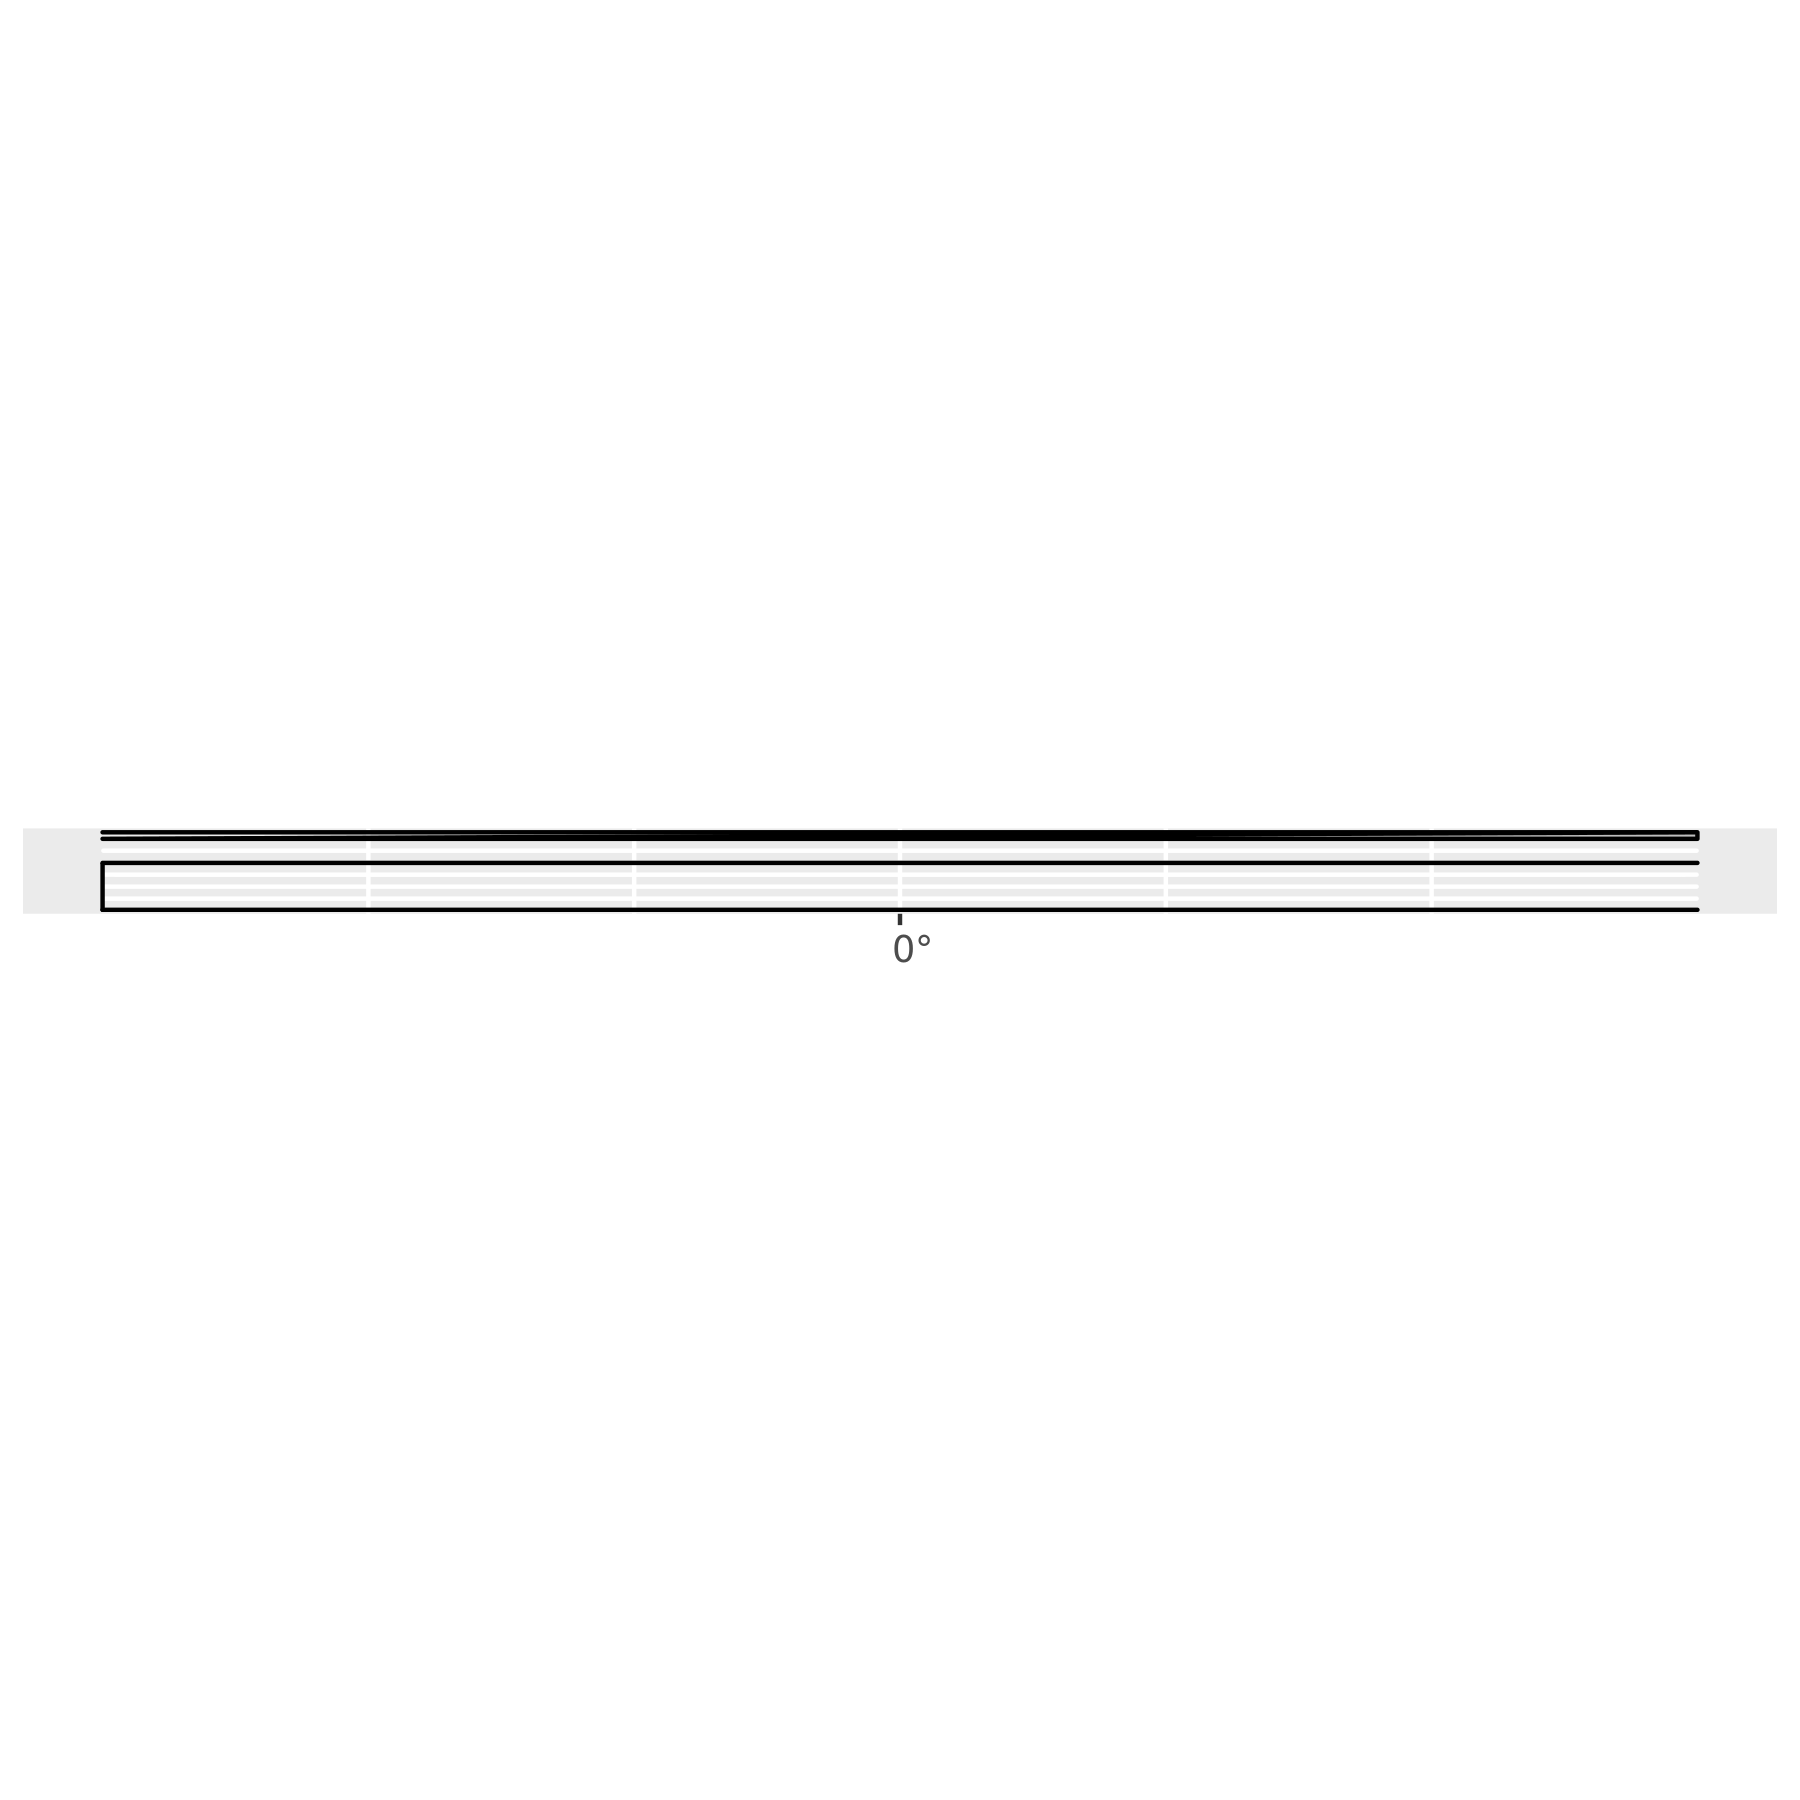

In [59]:
#world <- crop(ne_countries(scale = "medium", returnclass = "sp"), ext)
#world <- ne_countries(scale = "medium", returnclass = "sf") 
world = st_crop(x = ne_countries(scale = "medium", returnclass = "sf") %>% st_make_valid() , 
                #y = ext)
                y = st_as_sfc(st_bbox(c(xmin= ext[1], ymin = ext[3], xmax = ext[2], ymax = ext[4])), crs = 4326) )
ggplot(data = world, aes(group = admin)) +
  geom_sf(fill = "grey")